In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.95  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [2]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
# common_prec_prec = layers.Dense(round(num_hidden/2), activation="relu")(inputs)
# common_prec = layers.Dense(round(num_hidden/4), activation="relu")(common)
# common = layers.Dense(round(num_hidden/8), activation="relu")(common_prec)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

2021-09-08 11:43:26.618387: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          640         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            258         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            129         dense[0][0]                      
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
__________________________

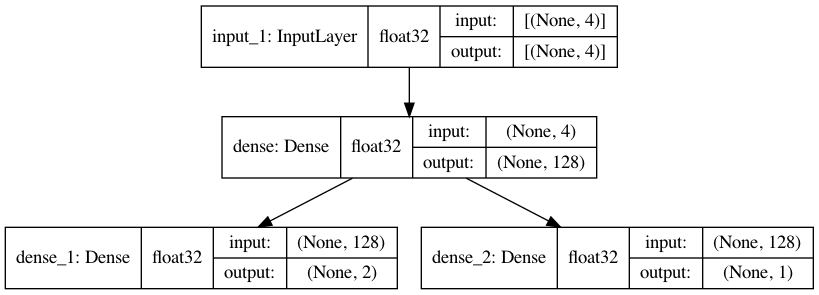

In [4]:
tf.keras.utils.plot_model(
    model,
#     to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [5]:
%%time
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
#         returns = np.array(returns)
#         returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
#         returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 14.81 at episode 10
running reward: 26.86 at episode 20
running reward: 32.85 at episode 30
running reward: 42.19 at episode 40
running reward: 47.61 at episode 50
running reward: 45.98 at episode 60
running reward: 49.75 at episode 70
running reward: 61.76 at episode 80
running reward: 56.10 at episode 90
running reward: 58.10 at episode 100
running reward: 68.26 at episode 110
running reward: 100.58 at episode 120
running reward: 96.36 at episode 130
running reward: 79.20 at episode 140
running reward: 113.46 at episode 150
running reward: 117.42 at episode 160
running reward: 140.67 at episode 170
running reward: 119.58 at episode 180
running reward: 96.68 at episode 190
running reward: 106.83 at episode 200
running reward: 100.63 at episode 210
running reward: 74.33 at episode 220
running reward: 61.66 at episode 230
running reward: 62.39 at episode 240
running reward: 96.36 at episode 250
running reward: 119.98 at episode 260
running reward: 127.25 at episode 270
r

In [17]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
state = env.reset()

for i in range(1, 1000):
    env.render(); # Adding this line would show the attempts
    # of the agent in a pop up window.

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    # Predict action probabilities and estimated future rewards
    # from environment state
    action_probs, critic_value = model(state)

    # Sample action from action probability distribution
    action = np.random.choice(num_actions, p=np.squeeze(action_probs))

    # Apply the sampled action in our environment
    state, reward, done, info = env.step(action)

    if done:
        print(i)
        break
env.close()

2021-09-07 21:12:14.703 python[84606:5711452] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcd38b2a040>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 21:12:14.704 python[84606:5711452] Warning: Expected min height of view: (<NSButton: 0x7fcd1a0c7bb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 21:12:14.707 python[84606:5711452] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcd192e2760>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 21:12:14.709 python[84606:5711452] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcd19284b20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


200


In [6]:
%time
1+1

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.87 µs


2